In [1]:
import numpy as np
import pandas as pd
import os
import math
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, roc_curve
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

/opt/conda/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2022-11-29 02:59:33.599795: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-29 02:59:34.165956: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-29 02:59:34.332310: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Cou

In [2]:
data = pd.read_csv('healthcare-dataset-stroke-data.csv')

In [3]:
data

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


### EDA

In [4]:
data.gender.value_counts(dropna=False)

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

<AxesSubplot:>

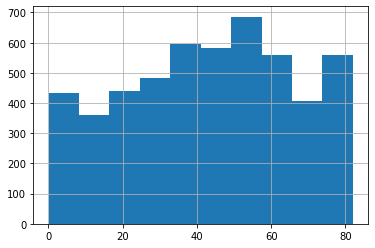

In [5]:
data.age.hist()

In [6]:
data.hypertension.value_counts(dropna=False)

0    4612
1     498
Name: hypertension, dtype: int64

In [7]:
data.heart_disease.value_counts(dropna=False)

0    4834
1     276
Name: heart_disease, dtype: int64

In [8]:
data.ever_married.value_counts(dropna=False)

Yes    3353
No     1757
Name: ever_married, dtype: int64

In [9]:
data.work_type.value_counts(dropna=False)

Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64

In [10]:
data.Residence_type.value_counts(dropna=False)

Urban    2596
Rural    2514
Name: Residence_type, dtype: int64

<AxesSubplot:>

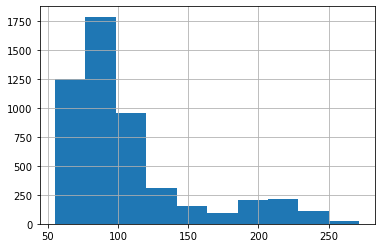

In [11]:
data.avg_glucose_level.hist()

<AxesSubplot:>

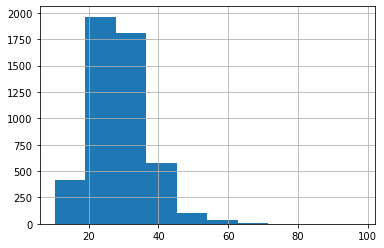

In [12]:
data.bmi.hist()

In [13]:
data.smoking_status.value_counts(dropna=False)

never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64

In [14]:
data.stroke.value_counts(dropna=False)

0    4861
1     249
Name: stroke, dtype: int64

### Data Preprocessing

In [15]:
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [16]:
numeric_features = ["age", "avg_glucose_level", "bmi"]

numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")),  
           ("scaler", StandardScaler())] #z-score
)

categorical_features = ["gender", "hypertension", "heart_disease", "ever_married", "work_type", "Residence_type", "smoking_status"]

categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)


### PCA

In [17]:
one_hot_encoder = OneHotEncoder(handle_unknown='ignore')

In [18]:
cat_col_df = data[categorical_features]

In [19]:
one_hot_encoder.fit(cat_col_df)

OneHotEncoder(handle_unknown='ignore')

In [20]:
one_hot_encoder.categories_

[array(['Female', 'Male', 'Other'], dtype=object),
 array([0, 1]),
 array([0, 1]),
 array(['No', 'Yes'], dtype=object),
 array(['Govt_job', 'Never_worked', 'Private', 'Self-employed', 'children'],
       dtype=object),
 array(['Rural', 'Urban'], dtype=object),
 array(['Unknown', 'formerly smoked', 'never smoked', 'smokes'],
       dtype=object)]

In [21]:
one_hot_df = pd.DataFrame(one_hot_encoder.transform(data[categorical_features]).toarray())

In [22]:
one_hot_df.shape

(5110, 20)

In [23]:
one_hot_df.columns=['Female', 'Male', 'Other', 'hypertension_0', 'hypertension_1', 'heart_disease_0', 'heart_disease_1', 'not_married', 'married', 'Govt_job',
                  'Never_worked', 'Private', 'Self-employed', 'children', 'Rural', 'Urban', 'Unknown', 'formerly_smoked', 'never_smoked', 'smokes']

In [24]:
one_hot_df

,Female,Male,Other,hypertension_0,hypertension_1,heart_disease_0,heart_disease_1,not_married,married,Govt_job,Never_worked,Private,Self-employed,children,Rural,Urban,Unknown,formerly_smoked,never_smoked,smokes
0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
5106,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
5107,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
5108,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [25]:
num_col_df = data[numeric_features]

In [26]:
num_col_df

,age,avg_glucose_level,bmi
0,67.0,228.69,36.6
1,61.0,202.21,NaN
2,80.0,105.92,32.5
3,49.0,171.23,34.4
4,79.0,174.12,24.0
...,...,...,...
5105,80.0,83.75,NaN
5106,81.0,125.20,40.0
5107,35.0,82.99,30.6
5108,51.0,166.29,25.6


In [27]:
scaler = StandardScaler()
median_imputer = SimpleImputer(strategy="median")
median_imputer.fit(num_col_df)
imputed_df = pd.DataFrame(median_imputer.transform(num_col_df))
scaler.fit(imputed_df)
scaler_df = pd.DataFrame(scaler.transform(imputed_df))

In [28]:
scaler_df.columns = ['age_std', 'avg_glucose_level_std', 'bmi_std']

In [29]:
full_data = one_hot_df.merge(scaler_df, left_index=True, right_index=True)

In [30]:
pca = PCA()
X_pca = pca.fit_transform(full_data)
total_explained_variance = pca.explained_variance_ratio_.cumsum()
n_over_95 = len(total_explained_variance[total_explained_variance >= .95])
n_to_reach_95 = X_pca.shape[1] - n_over_95 + 1

In [31]:
print("Number features: {0}, Total Variance Explained: {1}".format(n_to_reach_95, total_explained_variance[n_to_reach_95-1]))

Number features: 11, Total Variance Explained: 0.9526782238274881


In [32]:
X_pca = full_data

In [33]:
y_pca = data.iloc[:, -1]

In [34]:
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y_pca, test_size=0.2, random_state=0)

In [35]:
pipe = Pipeline([('scaler', StandardScaler()),
                 ('pca', PCA(n_components=n_to_reach_95)),
                 ('clf', RandomForestClassifier())])

pipe.fit(X_train_pca,y_train_pca)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=11)),
                ('clf', RandomForestClassifier())])

In [36]:
model = pipe.steps[1][1]
n_pcs= model.components_.shape[0]
initial_feature_names = X_train_pca.columns
most_important = [np.abs(model.components_[i]).argmax() for i in range(n_pcs)]

In [37]:
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

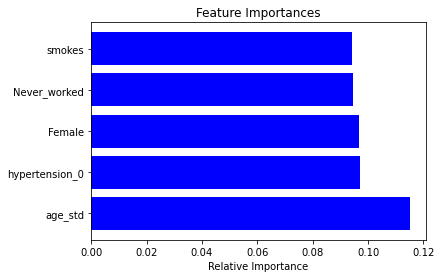

In [38]:
zipped_feats = zip(most_important_names, pipe.steps[2][1].feature_importances_)
zipped_feats = sorted(zipped_feats, key=lambda x: x[1], reverse=True)
features, importances = zip(*zipped_feats)
top_features = features[:5]
top_importances = importances[:5]
plt.title('Feature Importances')
plt.barh(range(len(top_importances)), top_importances, color='b', align='center')
plt.yticks(range(len(top_importances)), top_features)
plt.xlabel('Relative Importance')
plt.show()

In [39]:
print("model score: %.3f" % pipe.score(X_test_pca,y_test_pca))

model score: 0.947


## Logistic Regression

In [40]:
clf = Pipeline(
    steps=[("preprocessor", preprocessor), 
           ("classifier", LogisticRegression())]
)

In [41]:
X = data.iloc[:, 1:-1]

In [42]:
y = data.iloc[:, -1]

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [44]:
clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))

model score: 0.948


In [45]:
def conf_matrix(y,pred):
    ((tn, fp), (fn, tp)) = confusion_matrix(y, pred)
    ((tnr,fpr),(fnr,tpr))= confusion_matrix(y, pred, 
            normalize='true')
    return pd.DataFrame([[f'TN = {tn} (TNR = {tnr:1.2%})', 
                                f'FP = {fp} (FPR = {fpr:1.2%})'], 
                         [f'FN = {fn} (FNR = {fnr:1.2%})', 
                                f'TP = {tp} (TPR = {tpr:1.2%})']],
            index=['True 0', 'True 1'], 
            columns=['Pred 0', 'Pred 1'])

High accuracy because the model predicts 0 all the time.

In [46]:
ypred_ls = clf.predict(X_test)
conf_matrix(y_test, ypred_ls)

,Pred 0,Pred 1
True 0,TN = 968 (TNR = 100.00%),FP = 0 (FPR = 0.00%)
True 1,FN = 53 (FNR = 98.15%),TP = 1 (TPR = 1.85%)


### Over Sampling

In [47]:
X, y = full_data, data.iloc[:, -1]
sm = SMOTE(random_state=42)
X_sampled, y_sampled = sm.fit_resample(X, y)

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f2007d2ef70>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


In [48]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_sampled, y_sampled, test_size=0.25, random_state=0)

In [49]:
ls = LogisticRegression()

ls.fit(X_train1, y_train1)
print("model score: %.3f" % ls.score(X_test1, y_test1))

model score: 0.794


In [50]:
ypred_ls1 = ls.predict(X_test1)
conf_matrix(y_test1, ypred_ls1)

,Pred 0,Pred 1
True 0,TN = 910 (TNR = 74.84%),FP = 306 (FPR = 25.16%)
True 1,FN = 194 (FNR = 15.97%),TP = 1021 (TPR = 84.03%)


## Random Forest (On the oversampled data)

In [51]:
rf = RandomForestClassifier(random_state=0)

In [52]:
rf.fit(X_train1, y_train1)
print("model score: %.3f" % rf.score(X_test1, y_test1))
ypred_rf = rf.predict(X_test1)

model score: 0.961


In [53]:
conf_matrix(y_test1,ypred_rf)

,Pred 0,Pred 1
True 0,TN = 1157 (TNR = 95.15%),FP = 59 (FPR = 4.85%)
True 1,FN = 35 (FNR = 2.88%),TP = 1180 (TPR = 97.12%)


## ANN

In [65]:
X1 = np.asarray(X_sampled).astype(np.float32)
y1 = np.asarray(y_sampled).astype(np.float32)

In [75]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X1, y1, test_size=0.25, random_state=0)

In [68]:
model=keras.Sequential([
    keras.layers.Dense(100,input_shape=[23], activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(200, input_shape=[10], activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1,activation="sigmoid")
])
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
model.fit(X_train2, y_train2, epochs=30, batch_size=4)

Epoch 1/50
1823/1823 [==============================] - 7s 4ms/step - loss: 0.4528 - accuracy: 0.7875
Epoch 2/50
1823/1823 [==============================] - 7s 4ms/step - loss: 0.3927 - accuracy: 0.8249
Epoch 3/50
1823/1823 [==============================] - 7s 4ms/step - loss: 0.3539 - accuracy: 0.8483
Epoch 4/50
1823/1823 [==============================] - 6s 4ms/step - loss: 0.3228 - accuracy: 0.8591
Epoch 5/50
1823/1823 [==============================] - 7s 4ms/step - loss: 0.3079 - accuracy: 0.8681
Epoch 6/50
1823/1823 [==============================] - 7s 4ms/step - loss: 0.2876 - accuracy: 0.8767
Epoch 7/50
1823/1823 [==============================] - 6s 4ms/step - loss: 0.2731 - accuracy: 0.8808
Epoch 8/50
1823/1823 [==============================] - 6s 4ms/step - loss: 0.2592 - accuracy: 0.8952
Epoch 9/50
1823/1823 [==============================] - 7s 4ms/step - loss: 0.2536 - accuracy: 0.8937
Epoch 10/50
1823/1823 [==============================] - 7s 4ms/step - loss: 0.238

KeyboardInterrupt: 

In [76]:
ypred_ann=model.predict(X_test2).flatten()
ypred_ann = np.round(ypred_ann)

76/76 [==============================] - 0s 1ms/step


In [77]:
conf_matrix(y_test2, ypred_ann)

,Pred 0,Pred 1
True 0,TN = 1075 (TNR = 88.40%),FP = 141 (FPR = 11.60%)
True 1,FN = 28 (FNR = 2.30%),TP = 1187 (TPR = 97.70%)
